# ABL with MMC demo

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC

# Load the libraries
import numpy as np
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the case
case = amrwind.MyApp.init_nogui()

In [3]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 30000.0)
case.setAMRWindInput('time.max_step',  50)

case.setAMRWindInput('time.fixed_dt',  1.0)
case.setAMRWindInput('time.checkpoint_interval',  -1)

In [4]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.771e-05)           # dynamic viscosity, based on median air temperature of 284.47 K from 2 m above E06, units Pa-s
case.setAMRWindInput('incflo.density',      1.2456)              # density, based on 1017.13*100./(284.47)/287.058 where 1017.13 is median air pressure from 2 m above E06 
                                                                 #   and 284.47 is median air temperature from 2 m above E06, units kg/
case.setAMRWindInput('incflo.velocity',      [0, 0, 0])

In [5]:
# To set up the sampling output
case.setAMRWindInput('time.plot_interval',        -1) 

In [6]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

#case.setAMRWindInput('incflo.do_initial_proj', 0)
#case.setAMRWindInput('incflo.initial_iterations', 0)


In [7]:
# Sets up the domain and level 0 mesh
case.setAMRWindInput('geometry.prob_lo', [   0.0,    0.0, 0.0 ])
case.setAMRWindInput('geometry.prob_hi', [1000.0,  1000.0, 1000.0])   # each number must be divisible by 16
case.setAMRWindInput('amr.n_cell',       [32,      32,     32])

In [8]:
# This cell sets up boundary conditions
case.setAMRWindInput('is_periodicx', True)     # periodic in x
case.setAMRWindInput('is_periodicy', True)     # periodic in y
case.setAMRWindInput('is_periodicz', False)    # Enforce some boundary conditions in z

In [9]:
# Boundary conditions in z
case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')    

In [10]:
# Now set up ABL specific forces, parameters, etc.
case.setAMRWindInput('ICNS.source_terms',            ['BoussinesqBuoyancy','ABLMesoForcingMom',])
case.setAMRWindInput('Temperature.source_terms',     ['ABLMesoForcingTemp',])

case.setAMRWindInput('ABL.stats_output_frequency',   1, forcechange=True)           # Output ABL stats every iteration            
case.setAMRWindInput('ABL.stats_output_format',   'netcdf', forcechange=True)       # Use netcdf output because that's how we postprocess

case.setAMRWindInput('ABLForcing.abl_forcing_height',   150)       # Hub height wind speed you want specify 
case.setAMRWindInput('ABL.kappa',                       0.4)      # Kolmogorov constant

case.setAMRWindInput('ABL.normal_direction',      2)              # vertical is in z
case.setAMRWindInput('ABL.surface_roughness_z0',  0.0001)           # Surface roughess, SOMETHING WE WILL PROBABLY WANT TO ITERATE ON
case.setAMRWindInput('ABL.reference_temperature', 300.0)        # Correspond to what was measured at ARM

case.setAMRWindInput('ABL.perturb_temperature',    False, forcechange=True)
case.setAMRWindInput('ABL.perturb_velocity',       False, forcechange=True)

# Monin-Obukhov parameters (No need to change)
case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 300.0)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


## MMC parameters

In [11]:
zMMC     = [0, 500, 1000]     # heights of the MMC forcing
times    = [0, 10, 20, 50]    # Times of the MMC forcing

# U profiles from mesoscale
udat = np.array([[0, 1, 1],
                 [0, 1, 1],
                 [0, 2, 2],
                 [0, 2, 2],
                ])

# V profiles from mesoscale
vdat = np.array([[0, 0, 0], 
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
             ])

# T profiles from mesoscale
Tdat = np.array([[300, 300, 300], 
                 [300, 300, 300],
                 [300, 300, 300],
                 [300, 300, 300],
                ])

fluxdat = 0.0*np.array(times)
ICfilename  = 'init.nc'
MMCfilename = 'MMC.nc'
tstart      = 0.0



(0.0, 1000.0)

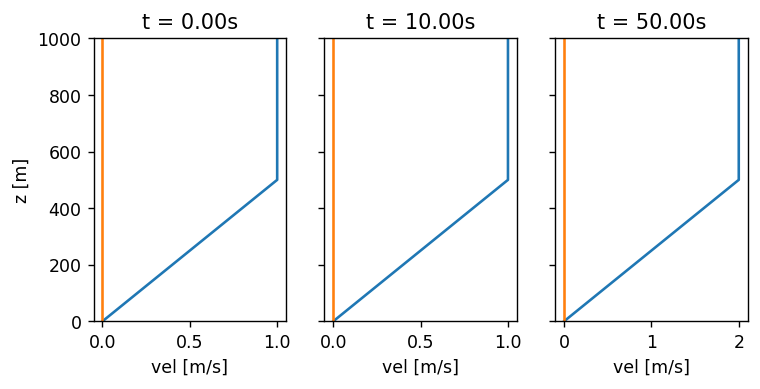

In [12]:
# Plot the MMC inputs
plottimes = [0, 1, -1]

fig, axs = plt.subplots(1, len(plottimes), figsize=(2.25*len(plottimes), 3), dpi=125, sharey=True)
for ploti, itime in enumerate(plottimes):
    axs[ploti].plot(udat[itime, :], zMMC, label='U')
    axs[ploti].plot(vdat[itime, :], zMMC, label='V')
    axs[ploti].set_title('t = %0.2fs'%times[itime])
    axs[ploti].set_xlabel('vel [m/s]')
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([min(zMMC), max(zMMC)])

(0.0, 1000.0)

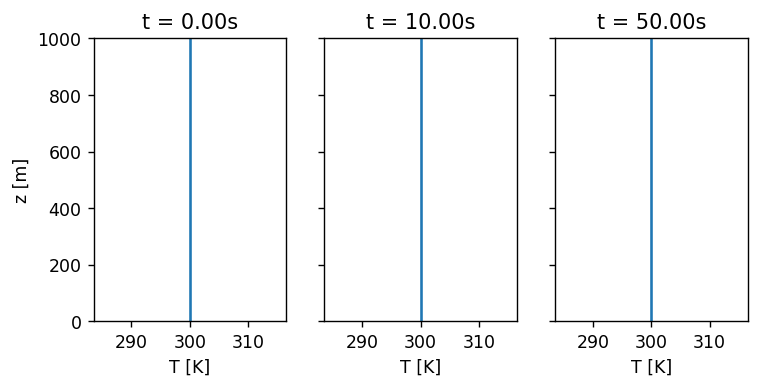

In [13]:
# Plot the MMC inputs
plottimes = [0, 1, -1]

fig, axs = plt.subplots(1, len(plottimes), figsize=(2.25*len(plottimes), 3), dpi=125, sharey=True)
for ploti, itime in enumerate(plottimes):
    axs[ploti].plot(Tdat[itime, :], zMMC)
    axs[ploti].set_title('t = %0.2fs'%times[itime])
    axs[ploti].set_xlabel('T [K]')
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([min(zMMC), max(zMMC)])

In [14]:
# Set the MMC inputs
zstr, Tstr = writeMMC.makeIC_fromMMC(case.getAMRWindInput('geometry.prob_lo'), 
                                     case.getAMRWindInput('geometry.prob_hi'), 
                                     case.getAMRWindInput('amr.n_cell'), 
                                     udat, vdat, Tdat,
                                     times, zMMC, ICfilename, tstart, verbose=True)
writeMMC.makeMMCforcing(case.getAMRWindInput('geometry.prob_lo'), 
                        case.getAMRWindInput('geometry.prob_hi'), 
                        case.getAMRWindInput('amr.n_cell'), 
                        udat, vdat, Tdat, fluxdat,
                        times, zMMC, MMCfilename)

# These inputs set up the initial temperature profile (Same as Nalu-Wind temperature profile)
case.setAMRWindInput('ABL.temperature_heights', zstr)
case.setAMRWindInput('ABL.temperature_values',  Tstr)

# MMC files
case.setAMRWindInput('ABL.initial_condition_input_file', ICfilename) # this is only for u,v
case.setAMRWindInput('ABL.mesoscale_forcing', MMCfilename)

case.setAMRWindInput('ABLMesoForcingMom.forcing_scheme', "direct")
case.setAMRWindInput('ABLMesoForcingTemp.forcing_scheme', "direct")

[============================================================] 100.0% 
[============================================================] 100.0% 
[============================================================] 100.0% 
NETCDF4
Wrote heights and times
Wrote momentum profiles
Wrote temperature profiles
Wrote tflux profiles
Done


In [15]:
# Write the input file
print(case.writeAMRWindInput('ablmmc.inp'))

# --- Simulation time control parameters ---
time.stop_time                           = 30000.0             # Max (simulated) time to evolve [s]
time.max_step                            = 50                  
time.fixed_dt                            = 1.0                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = -1                  
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol             